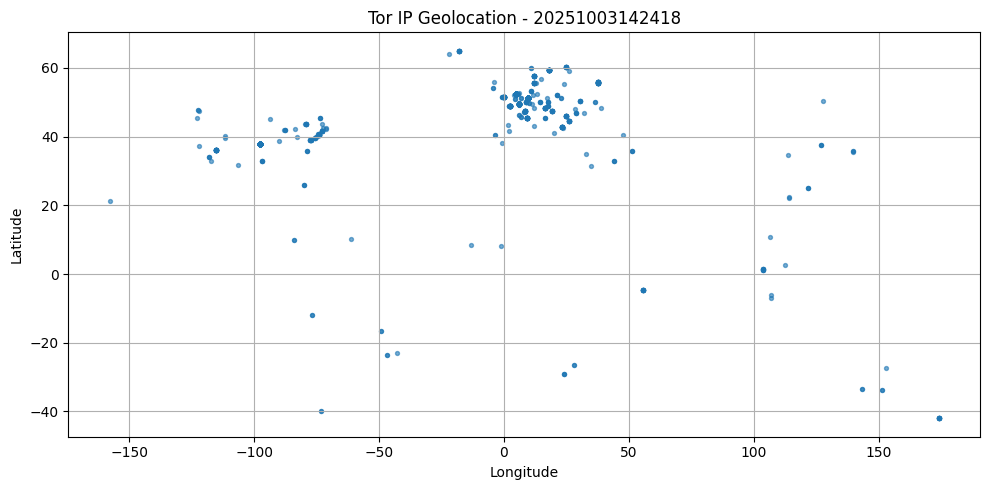

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os, zipfile, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# ===== 設定 =====
ZIP_PATH = "./isolation_forest.zip"     # 置き場所に合わせて調整
EXTRACT_DIR = "./isolation_forest_all"  # 展開先

# ===== ZIP展開 =====
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# ===== CSV列挙 =====
csv_files = []
for root, _, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))
csv_files.sort()
print(f"発見CSVファイル数: {len(csv_files)}")

# ===== 緯度経度列の検出 =====
def detect_lat_lon_columns(columns):
    # まず完全一致系
    lat = next((c for c in columns if c.lower() in ["latitude", "lat", "y", "lat_deg"]), None)
    lon = next((c for c in columns if c.lower() in ["longitude", "lon", "lng", "x", "long", "lon_deg"]), None)
    # だめなら部分一致
    if lat is None:
        lat = next((c for c in columns if "lat" in c.lower()), None)
    if lon is None:
        lon = next((c for c in columns if ("lon" in c.lower()) or ("lng" in c.lower()) or ("longi" in c.lower())), None)
    return lat, lon

# ===== IPv4 抽出のためのユーティリティ =====
IPV4_RE = re.compile(r"\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b")

def find_ipv4_in_text(text):
    if not isinstance(text, str):
        return None
    m = IPV4_RE.search(text)
    return m.group(0) if m else None

def detect_ip_column(df: pd.DataFrame):
    """IP列を可能なら返す。見つからなければ None。"""
    cols = list(df.columns)
    lower = [c.lower() for c in cols]

    # 1) 列名の優先候補
    name_prefs = ["ip", "ip_address", "source_ip", "src_ip", "dst_ip", "ipaddr", "address", "remote_ip", "client_ip"]
    for p in name_prefs:
        if p in lower:
            return cols[lower.index(p)]

    # 2) 文字列型の列を走査し、IPv4を多く含む列を探す
    text_cols = [c for c in cols if df[c].dtype == "object"]
    if text_cols:
        sample_n = min(200, len(df))
        best_col, best_rate = None, 0.0
        for c in text_cols:
            series = df[c].astype(str).head(sample_n)
            hits = series.apply(lambda s: IPV4_RE.search(s) is not None).mean()
            if hits > best_rate:
                best_rate, best_col = hits, c
        # 閾値は緩め（例: 10%以上）で採用
        if best_col is not None and best_rate >= 0.10:
            return best_col

    # 3) 見つからなければ None（後段で行単位抽出にフォールバック）
    return None

# ===== 各ファイル処理 =====
for path in csv_files:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[SKIP] 読み込み失敗 {path}: {e}")
        continue

    lat_col, lon_col = detect_lat_lon_columns(df.columns)
    if not lat_col or not lon_col:
        print(f"[SKIP] {os.path.basename(path)}: 緯度/経度列が見つかりません -> {list(df.columns)}")
        continue

    # ---- 前処理（数値化・範囲フィルタ）----
    df = df.copy()
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df = df.dropna(subset=[lat_col, lon_col])
    df = df[(df[lat_col].between(-90, 90)) & (df[lon_col].between(-180, 180))]
    if len(df) < 5:
        print(f"[SKIP] {os.path.basename(path)}: 有効行が少ない (n={len(df)})")
        continue

    # ---- LOF（外れ値3%）----
    X = df[[lon_col, lat_col]].to_numpy()
    n = len(X)
    n_neighbors = max(10, min(35, int(n * 0.03)))
    if n_neighbors >= n:
        n_neighbors = max(5, n - 1)

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.03)
    y_pred = lof.fit_predict(X)              # 1=inlier, -1=outlier
    scores = lof.negative_outlier_factor_    # より負ほど異常

    is_out = (y_pred == -1)
    inliers = ~is_out

    # ---- IP列の検出 ＋ 行単位抽出フォールバック ----
    ip_col = detect_ip_column(df)
    ip_series = None
    if ip_col:
        ip_series = df[ip_col].astype(str)
    else:
        # 行ごとに、文字列列を連結して最初のIPv4を抽出
        text_cols = [c for c in df.columns if df[c].dtype == "object"]
        if text_cols:
            concat_text = df[text_cols].astype(str).agg(" ".join, axis=1)
            ip_series = concat_text.apply(lambda s: find_ipv4_in_text(s) or "")

    # ---- outlier IP の一覧（ユニーク/順序保持）----
    out_ips = []
    if ip_series is not None:
        for v in ip_series[is_out].tolist():
            ip = find_ipv4_in_text(v) if isinstance(v, str) else None
            if ip is None and isinstance(v, str) and IPV4_RE.fullmatch(v):
                ip = v
            if ip and ip not in out_ips:
                out_ips.append(ip)

    fname = os.path.basename(path).replace(".csv", "")
    print(f"\n📂 {fname}")
    print(f"  総点数: {n} / 正常: {int(inliers.sum())} / 異常: {int(is_out.sum())} (約 {is_out.sum()/n*100:.1f}% )")
    print(f"  n_neighbors={n_neighbors}  score(mean): inlier={scores[inliers].mean():.4f} / outlier={scores[is_out].mean():.4f}")

    if out_ips:
        print("  outlier IPs (最大50件):")
        for ip in out_ips[:50]:
            print(f"    - {ip}")
        if len(out_ips) > 50:
            print(f"    ... and {len(out_ips)-50} more")
    else:
        print("  (outlier 行からIPを特定できませんでした)")

    # ---- 可視化 ----
    plt.figure(figsize=(10, 5))
    plt.scatter(X[inliers, 0], X[inliers, 1], s=8, alpha=0.6, label="Inlier")
    plt.scatter(X[is_out, 0],  X[is_out, 1],  s=40, alpha=0.9, marker="x", label="Outlier")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"LOF (3% Outliers) - {fname}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
